In [ ]:
pip install mne

In [ ]:
!python --version


Python 3.10.12


In [ ]:
!pip install PyWavelets

In [ ]:

# Base libraries
from multiprocessing import Pool

import os #os: Used for interacting with the file system (e.g., listing files in a directory).
import numpy as np
import mne
import pandas as pd
import random

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
import mne
import matplotlib
from collections import defaultdict
from math import cos, sin, acos, radians, pi
from scipy.interpolate import griddata
from numpy import newaxis
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


# Wavelets
import pywt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Importing the data using multiprocessing

# 10x speed increase for reading 900 csv files


train_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TRAIN'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TEST'

# wrap your csv importer in a function that can be mapped
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)


# get a list of file names
files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir,filename) for filename in files_train if filename.split('.')[1]=='csv']

files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir,filename) for filename in files_test if filename.split('.')[1]=='csv']

# set up your pool
with Pool(processes=12) as pool:

    # pool maps the dataframe


    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test =  pool.map(read_csv, file_list_test)


# reduce the list of dataframes to a single dataframe
combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train,combined_df_test], ignore_index=True)


EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

EEG_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,14,FP1,0,-5.656,a,S1 obj,0,co2a0000369,0.000000
1,6,14,FP1,1,-6.632,a,S1 obj,0,co2a0000369,0.003906
2,7,14,FP1,2,-7.121,a,S1 obj,0,co2a0000369,0.007812
3,8,14,FP1,3,-9.074,a,S1 obj,0,co2a0000369,0.011719
4,9,14,FP1,4,-11.027,a,S1 obj,0,co2a0000369,0.015625


Mounted at /content/drive


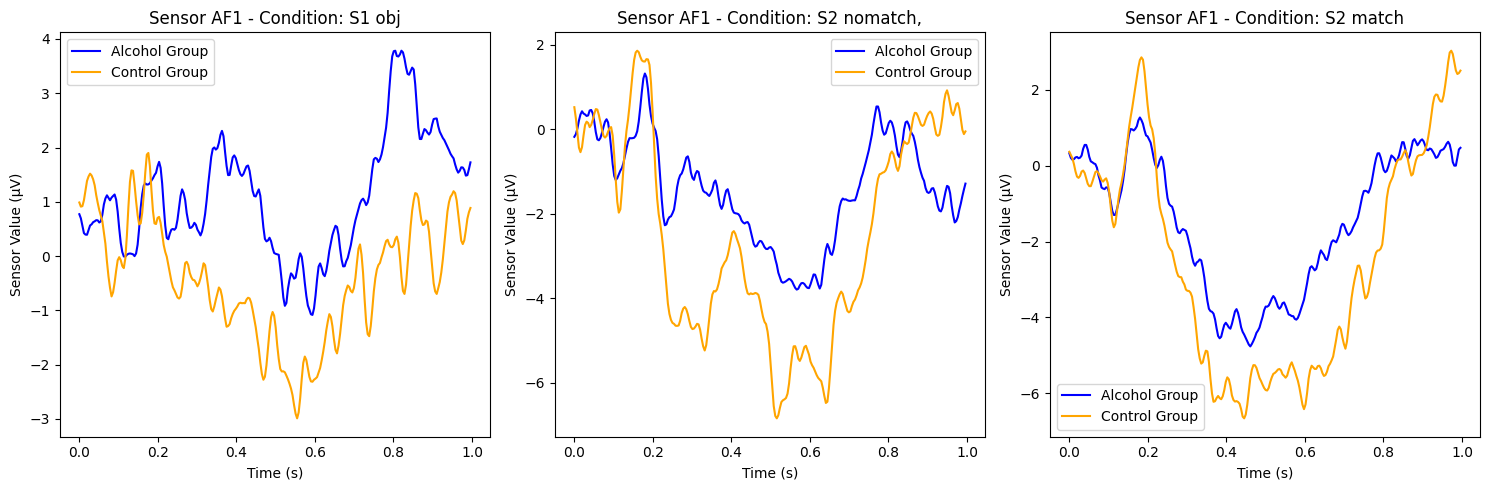

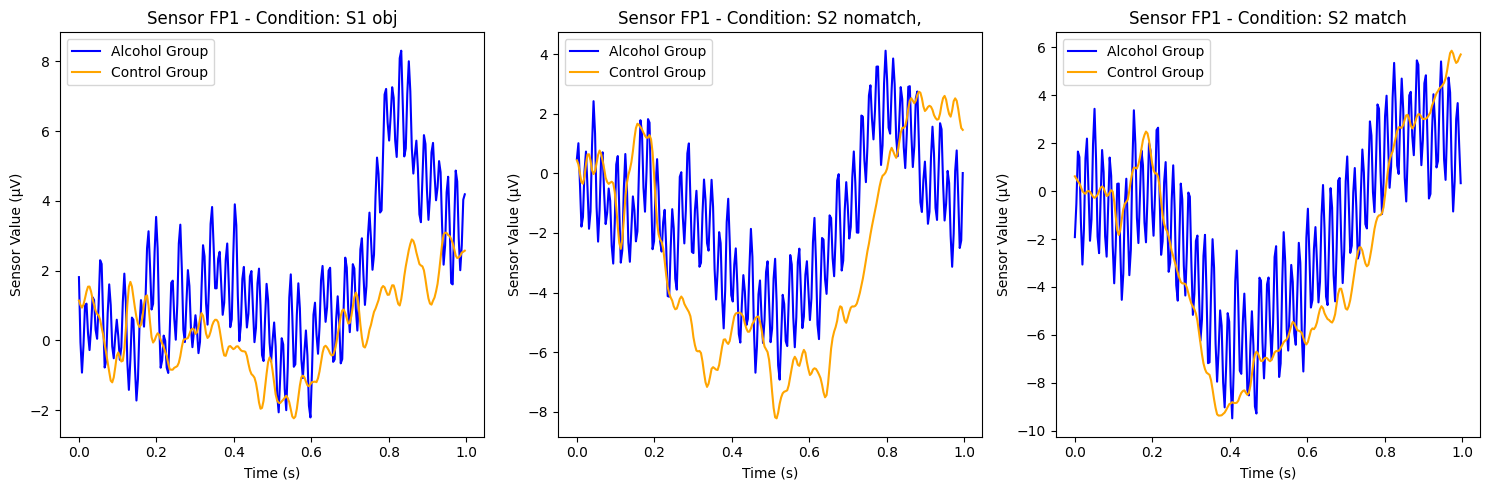

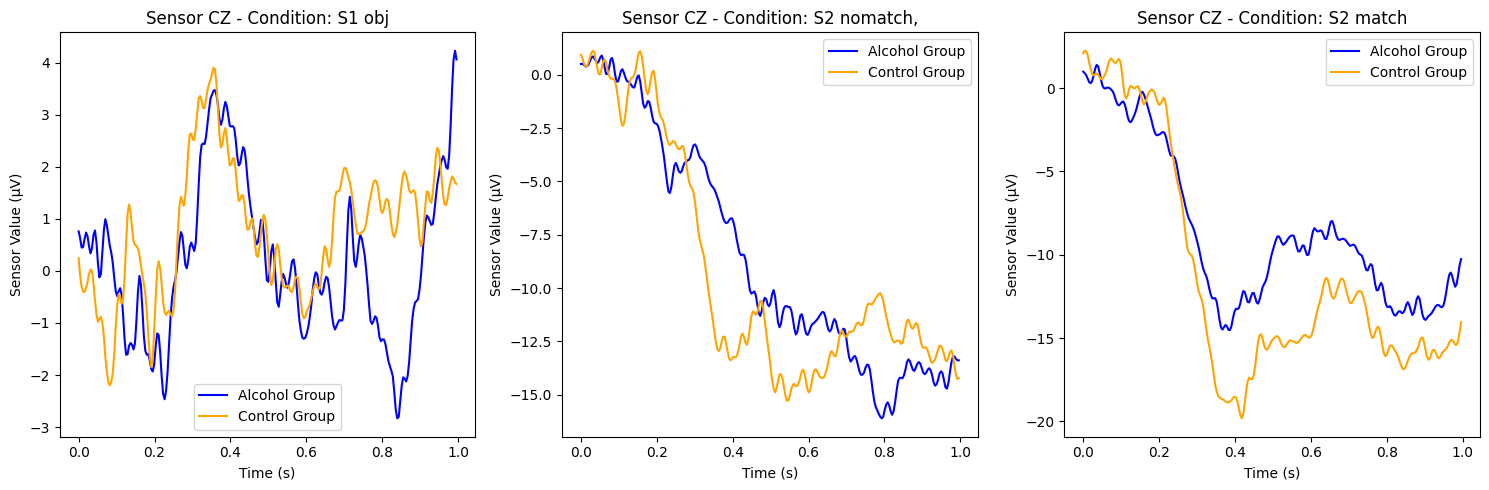

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Constants
sensors_to_plot = ['AF1', 'FP1', 'CZ']  # Specify the sensors you want to plot

# Wrap your CSV importer in a function that can be mapped
def read_csv(filename):
    'Converts a filename to a pandas dataframe'
    return pd.read_csv(filename)

# Get a list of file names
train_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TRAIN'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TEST'

files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir, filename) for filename in files_train if filename.endswith('.csv')]

files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir, filename) for filename in files_test if filename.endswith('.csv')]

# Set up your pool
with Pool(processes=12) as pool:
    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test = pool.map(read_csv, file_list_test)

# Reduce the list of dataframes to a single dataframe
combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train, combined_df_test], ignore_index=True)

# Filter data for subject 'a' (alcohol group) and 'c' (control group)
EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

# Function to plot data for specified sensors
def plot_eeg_data(df_alcohol, df_control, sensors):
    for sensor in sensors:
        plt.figure(figsize=(15, 5))
        for condition in df_alcohol['matching condition'].unique():
            plt.subplot(1, len(df_alcohol['matching condition'].unique()),
                        list(df_alcohol['matching condition'].unique()).index(condition) + 1)

            # Plot for alcohol group
            subset_alcohol = df_alcohol[(df_alcohol['sensor position'] == sensor) &
                                        (df_alcohol['matching condition'] == condition)]
            if not subset_alcohol.empty:
                subset_alcohol.groupby('time')['sensor value'].mean().plot(
                    label='Alcohol Group', color='blue', linewidth=1.5)

            # Plot for control group
            subset_control = df_control[(df_control['sensor position'] == sensor) &
                                        (df_control['matching condition'] == condition)]
            if not subset_control.empty:
                subset_control.groupby('time')['sensor value'].mean().plot(
                    label='Control Group', color='orange', linewidth=1.5)

            plt.title(f'Sensor {sensor} - Condition: {condition}')
            plt.xlabel('Time (s)')
            plt.ylabel('Sensor Value (µV)')

            # Show legend only if data exists for both groups
            if not subset_alcohol.empty or not subset_control.empty:
                plt.legend()

        plt.tight_layout()
        plt.show()

# Call the plotting function for the specified sensors
plot_eeg_data(EEG_data, EEG_data_control, sensors_to_plot)


#Butterworth bandpass filter to the sensor values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


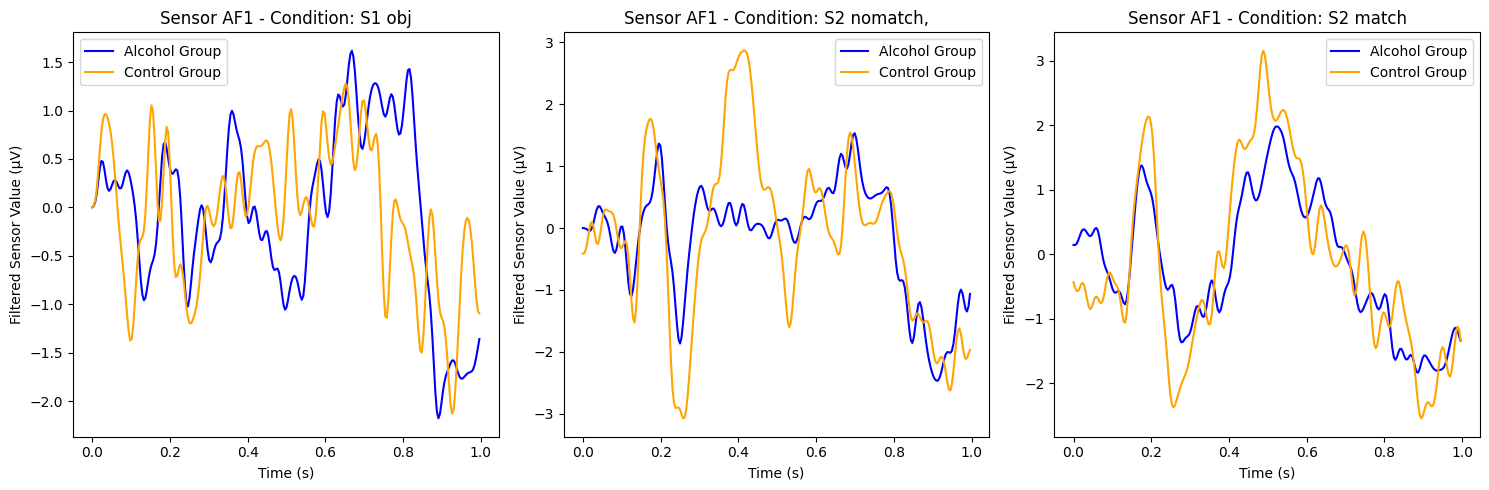

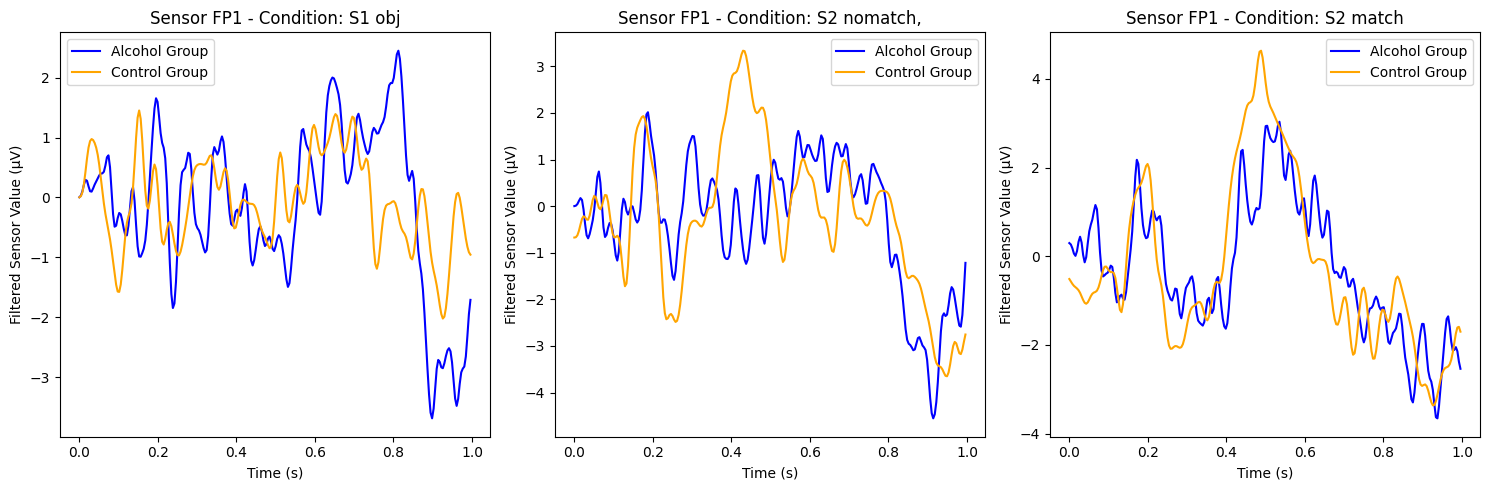

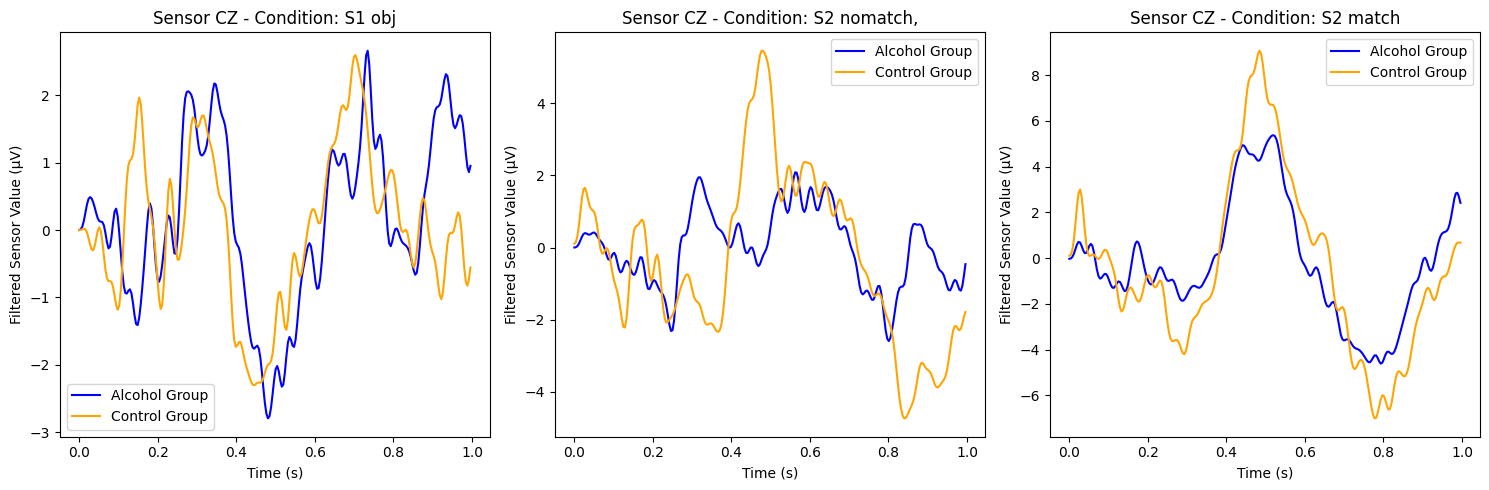

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from multiprocessing import Pool

# Constants
FS = 256  # Sampling frequency
#Sampling frequency of the EEG data (256 Hz).
#This indicates that 256 data points are recorded per second.


# Wrap your CSV importer in a function that can be mapped
def read_csv(filename):
    'Converts a filename to a pandas dataframe'
    return pd.read_csv(filename)

# Get a list of file names
train_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TRAIN'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TEST'

files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir, filename) for filename in files_train if filename.endswith('.csv')]

files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir, filename) for filename in files_test if filename.endswith('.csv')]

# Set up your pool
with Pool(processes=12) as pool:
    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test = pool.map(read_csv, file_list_test)

# Reduce the list of dataframes to a single dataframe
combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train, combined_df_test], ignore_index=True)

# Filter data for subject 'a' and 'c'
EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

# Butterworth Bandpass Filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):#order=5: The filter's order. Higher orders give sharper frequency cutoffs but can distort the signal.
    nyq = 0.5 * fs #nyq = 0.5 * fs: The Nyquist frequency, half of the sampling rate, which represents the highest frequency that can be analyzed.
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Apply Butterworth filter to the sensor value
def apply_filter(df):
  #lowcut and highcut: Lower and upper cutoff frequencies for the bandpass filter (e.g., 1 Hz to 30 Hz).
    df['filtered_sensor_value'] = butter_bandpass_filter(df['sensor value'], 1, 30, FS)
    return df

# Apply the filter to both alcohol (EEG_data) and control (EEG_data_control)
EEG_data_filtered = EEG_data.groupby(['name', 'trial number', 'sensor position']).apply(apply_filter).reset_index(drop=True)
EEG_data_control_filtered = EEG_data_control.groupby(['name', 'trial number', 'sensor position']).apply(apply_filter).reset_index(drop=True)

# Function to plot filtered data for selected sensors
def plot_filtered_data(df_alcohol, df_control, sensors):
    for sensor in sensors:
        plt.figure(figsize=(15, 5))
        for condition in df_alcohol['matching condition'].unique():
            plt.subplot(1, len(df_alcohol['matching condition'].unique()),
                        list(df_alcohol['matching condition'].unique()).index(condition) + 1)

            # Plot for alcohol group
            subset_alcohol = df_alcohol[(df_alcohol['sensor position'] == sensor) &
                                        (df_alcohol['matching condition'] == condition)]
            if not subset_alcohol.empty:
                subset_alcohol.groupby('time')['filtered_sensor_value'].mean().plot(
                    label='Alcohol Group', color='blue', linewidth=1.5)

            # Plot for control group
            subset_control = df_control[(df_control['sensor position'] == sensor) &
                                        (df_control['matching condition'] == condition)]
            if not subset_control.empty:
                subset_control.groupby('time')['filtered_sensor_value'].mean().plot(
                    label='Control Group', color='orange', linewidth=1.5)

            plt.title(f'Sensor {sensor} - Condition: {condition}')
            plt.xlabel('Time (s)')
            plt.ylabel('Filtered Sensor Value (µV)')

            # Only show legend if there is something to show
            if not subset_alcohol.empty or not subset_control.empty:
                plt.legend()

        plt.tight_layout()
        plt.show()


# Specify sensors to plot
sensors_to_plot = ['AF1', 'FP1', 'CZ']  # Replace with actual sensor names
plot_filtered_data(EEG_data_filtered, EEG_data_control_filtered, sensors_to_plot)


Butterworth Bandpass Filter:

>The butter_bandpass_filter() function applies a Butterworth filter to the data, keeping frequencies between lowcut and highcut.

>The filter is designed to allow signals in the range of 1 Hz to 30 Hz, which is typically the range of interest for EEG signals (e.g., delta, theta, alpha, and beta bands).

Filtering Process:

>The filtering is applied for each combination of name, trial number, and sensor position using the apply_filter() function, which applies the bandpass filter on the column 'sensor value'.

Plotting:

>The plot_eeg_data_for_all_sensors() function visualizes the filtered EEG data for different sensor positions and conditions, showing average filtered sensor values over time for different groups (a and c).

In EEG (electroencephalography) analysis, brain signals are categorized into different frequency bands, each associated with specific mental and physiological states. These frequency bands typically fall within the range of 1 Hz to 30 Hz, which is why this range is commonly targeted when processing EEG signals. Here's a breakdown of the relevant frequency bands within the 1 Hz to 30 Hz range:

1. **Delta (0.5 - 4 Hz)**:
   - Associated with deep sleep and unconscious states.
   - Typically seen in slow-wave sleep.

2. **Theta (4 - 8 Hz)**:
   - Linked to drowsiness, relaxation, and light sleep.
   - Involved in memory formation and creativity.

3. **Alpha (8 - 13 Hz)**:
   - Associated with relaxation, calmness, and quiet alertness.
   - Often observed when the eyes are closed and the brain is at rest.

4. **Beta (13 - 30 Hz)**:
   - Associated with active thinking, concentration, and problem-solving.
   - Present during cognitive and motor activities.

### Why the Filter is Designed for 1 Hz to 30 Hz:

- **Lowcut (1 Hz)**:
  - Signals below 1 Hz are typically noise or baseline drift, which do not provide meaningful information about brain activity in the context of EEG. The filter cuts these low-frequency components to clean up the data.
  
- **Highcut (30 Hz)**:
  - Frequencies above 30 Hz include muscle artifacts, power line noise (typically 50 or 60 Hz), and other high-frequency noise that could distort the EEG data. The filter cuts out these higher frequencies to focus on brain signals relevant to cognition, sleep, and motor control.

By focusing on the 1-30 Hz range, this filter isolates the brainwave activity that is most relevant for EEG studies (delta, theta, alpha, beta) and reduces the influence of noise or irrelevant signals.

#Comparison

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


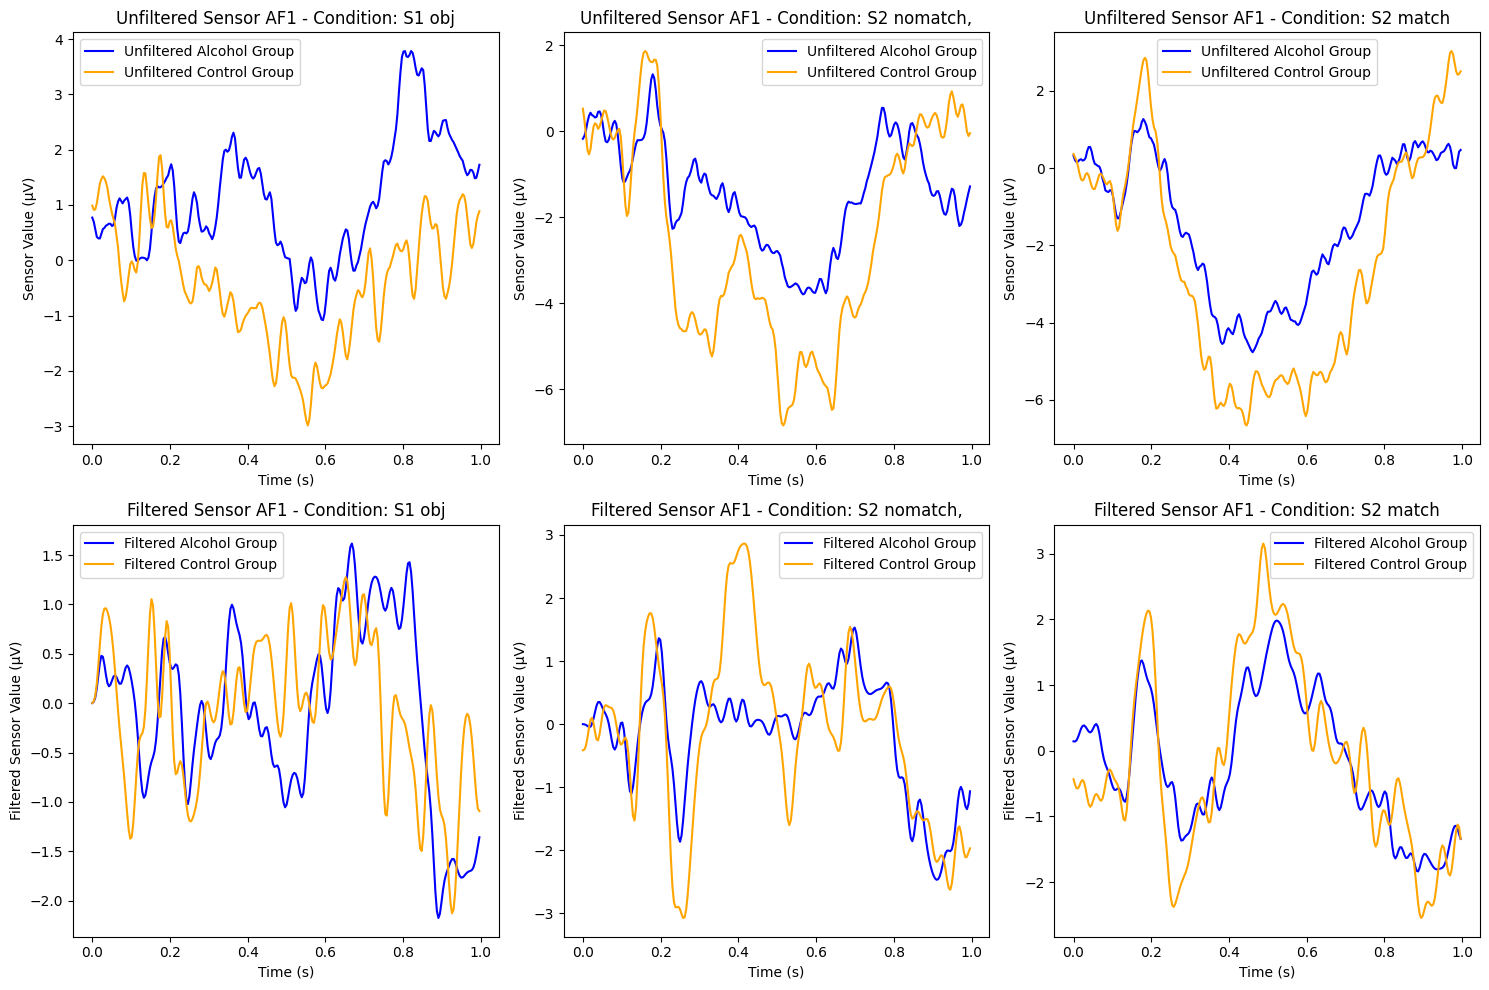

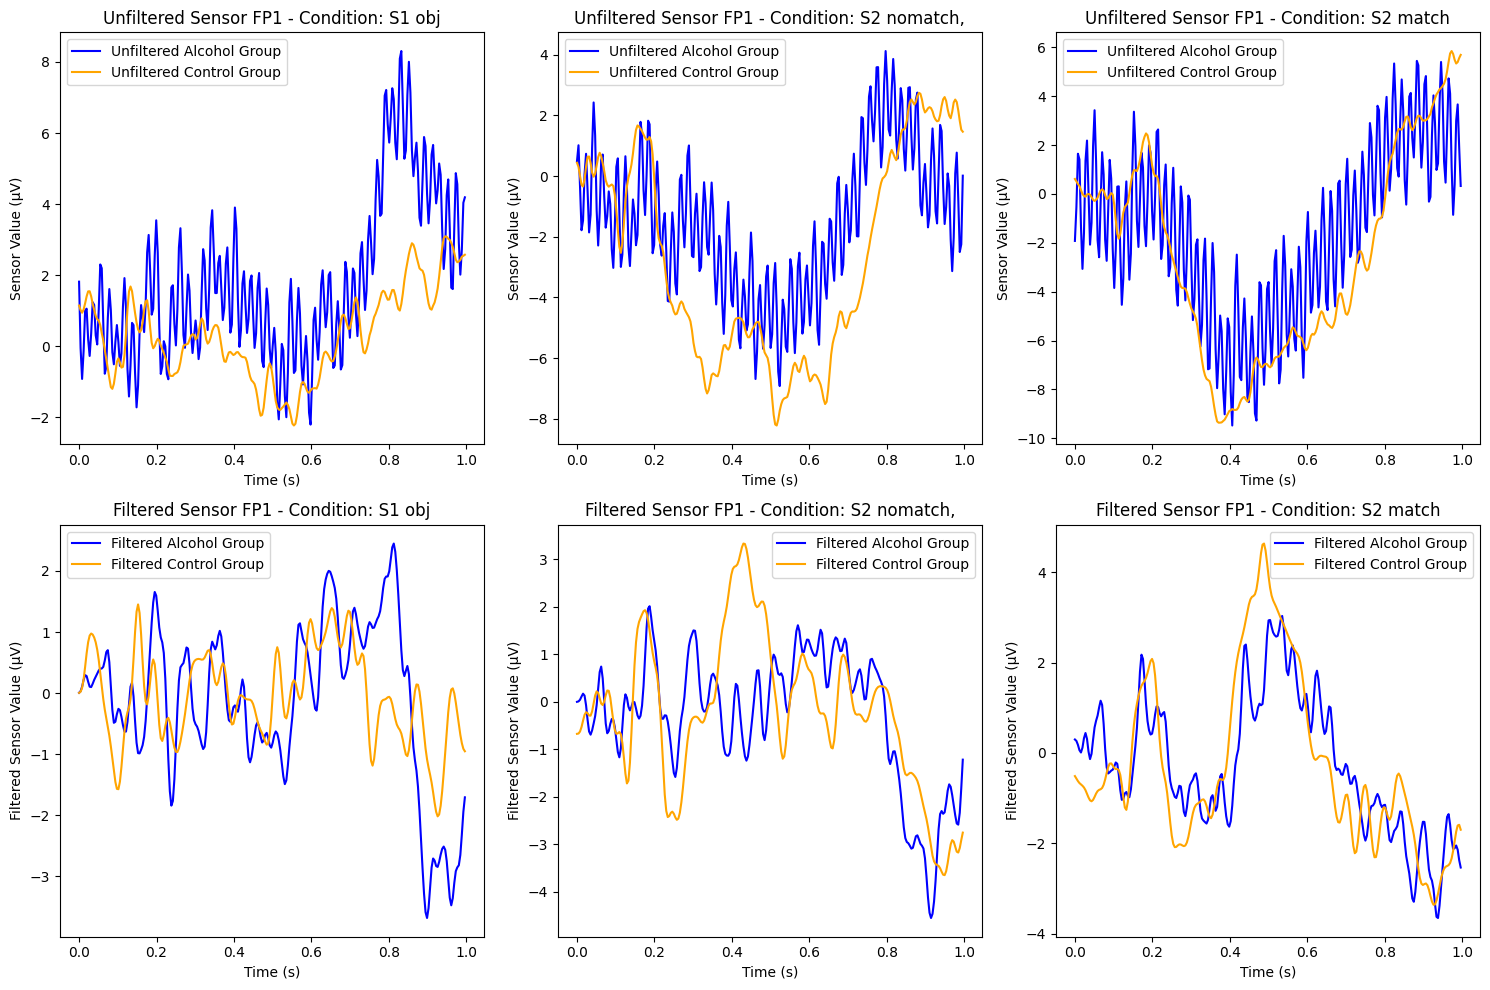

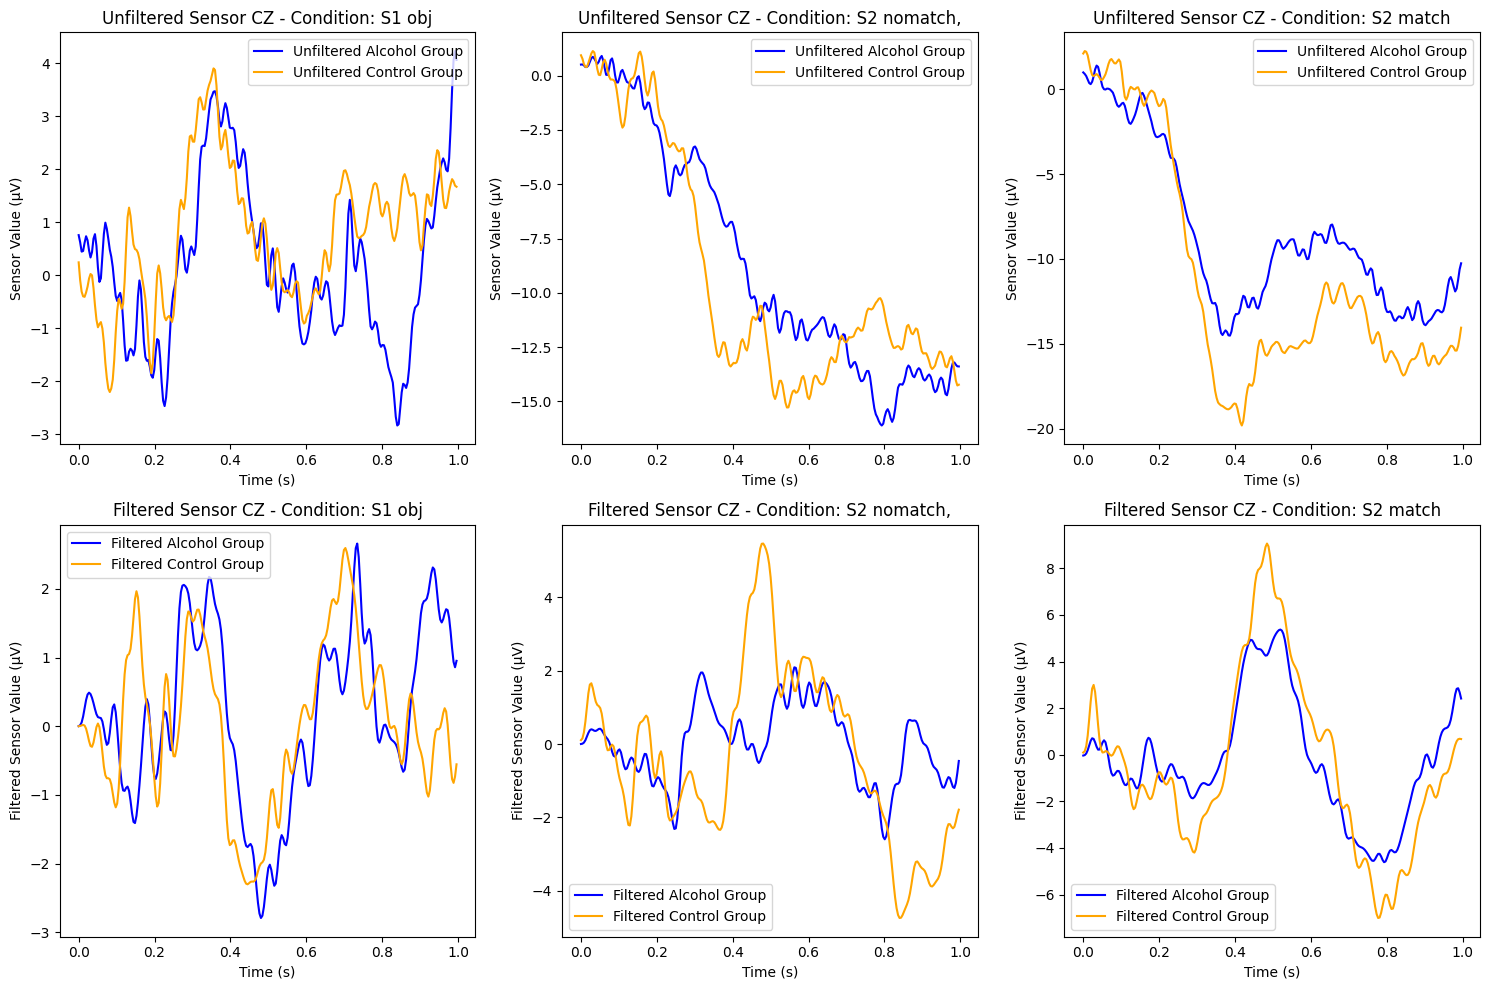

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from multiprocessing import Pool

# Constants
FS = 256  # Sampling frequency
sensors_to_plot = ['AF1', 'FP1', 'CZ']  # Specify the sensors you want to plot

# Wrap your CSV importer in a function that can be mapped
def read_csv(filename):
    'Converts a filename to a pandas dataframe'
    return pd.read_csv(filename)

# Get a list of file names
train_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TRAIN'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TEST'

files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir, filename) for filename in files_train if filename.endswith('.csv')]

files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir, filename) for filename in files_test if filename.endswith('.csv')]

# Set up your pool
with Pool(processes=12) as pool:
    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test = pool.map(read_csv, file_list_test)

# Reduce the list of dataframes to a single dataframe
combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train, combined_df_test], ignore_index=True)

# Filter data for subject 'a' (alcohol group) and 'c' (control group)
EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

# Butterworth Bandpass Filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Apply Butterworth filter to the sensor value
def apply_filter(df):
    df['filtered_sensor_value'] = butter_bandpass_filter(df['sensor value'], 1, 30, FS)
    return df

# Apply the filter to both alcohol (EEG_data) and control (EEG_data_control)
EEG_data_filtered = EEG_data.groupby(['name', 'trial number', 'sensor position']).apply(apply_filter).reset_index(drop=True)
EEG_data_control_filtered = EEG_data_control.groupby(['name', 'trial number', 'sensor position']).apply(apply_filter).reset_index(drop=True)

# Function to plot unfiltered and filtered data for selected sensors side by side
def plot_comparison(df_unfiltered_alcohol, df_unfiltered_control, df_filtered_alcohol, df_filtered_control, sensors):
    for sensor in sensors:
        plt.figure(figsize=(15, 10))

        # Plot for each condition
        for condition in df_unfiltered_alcohol['matching condition'].unique():
            plt.subplot(2, len(df_unfiltered_alcohol['matching condition'].unique()),
                        list(df_unfiltered_alcohol['matching condition'].unique()).index(condition) + 1)

            # Plot unfiltered data for alcohol group
            subset_unfiltered_alcohol = df_unfiltered_alcohol[(df_unfiltered_alcohol['sensor position'] == sensor) &
                                                              (df_unfiltered_alcohol['matching condition'] == condition)]
            if not subset_unfiltered_alcohol.empty:
                subset_unfiltered_alcohol.groupby('time')['sensor value'].mean().plot(
                    label='Unfiltered Alcohol Group', color='blue', linewidth=1.5)

            # Plot unfiltered data for control group
            subset_unfiltered_control = df_unfiltered_control[(df_unfiltered_control['sensor position'] == sensor) &
                                                              (df_unfiltered_control['matching condition'] == condition)]
            if not subset_unfiltered_control.empty:
                subset_unfiltered_control.groupby('time')['sensor value'].mean().plot(
                    label='Unfiltered Control Group', color='orange', linewidth=1.5)

            plt.title(f'Unfiltered Sensor {sensor} - Condition: {condition}')
            plt.xlabel('Time (s)')
            plt.ylabel('Sensor Value (µV)')
            if not subset_unfiltered_alcohol.empty or not subset_unfiltered_control.empty:
                plt.legend()

            # Plot filtered data for alcohol and control groups
            plt.subplot(2, len(df_unfiltered_alcohol['matching condition'].unique()),
                        len(df_unfiltered_alcohol['matching condition'].unique()) +
                        list(df_unfiltered_alcohol['matching condition'].unique()).index(condition) + 1)

            subset_filtered_alcohol = df_filtered_alcohol[(df_filtered_alcohol['sensor position'] == sensor) &
                                                          (df_filtered_alcohol['matching condition'] == condition)]
            if not subset_filtered_alcohol.empty:
                subset_filtered_alcohol.groupby('time')['filtered_sensor_value'].mean().plot(
                    label='Filtered Alcohol Group', color='blue', linewidth=1.5)

            subset_filtered_control = df_filtered_control[(df_filtered_control['sensor position'] == sensor) &
                                                          (df_filtered_control['matching condition'] == condition)]
            if not subset_filtered_control.empty:
                subset_filtered_control.groupby('time')['filtered_sensor_value'].mean().plot(
                    label='Filtered Control Group', color='orange', linewidth=1.5)

            plt.title(f'Filtered Sensor {sensor} - Condition: {condition}')
            plt.xlabel('Time (s)')
            plt.ylabel('Filtered Sensor Value (µV)')
            if not subset_filtered_alcohol.empty or not subset_filtered_control.empty:
                plt.legend()

        plt.tight_layout()
        plt.show()

# Plot comparison for the specified sensors
plot_comparison(EEG_data, EEG_data_control, EEG_data_filtered, EEG_data_control_filtered, sensors_to_plot)


In [ ]:
EEG_data=EEG_data_filtered
EEG_data_control=EEG_data_control_filtered

In [ ]:
EEG_data.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time,filtered_sensor_value
0,1033,0,AF1,0,-2.146,a,S1 obj,4,co2a0000364,0.000000,-0.004665
1,1034,0,AF1,1,-2.146,a,S1 obj,4,co2a0000364,0.003906,-0.040292
2,1035,0,AF1,2,-1.658,a,S1 obj,4,co2a0000364,0.007812,-0.165046
3,1036,0,AF1,3,-0.682,a,S1 obj,4,co2a0000364,0.011719,-0.429810
4,1037,0,AF1,4,2.248,a,S1 obj,4,co2a0000364,0.015625,-0.797100


In [ ]:
# standardizing the sensor position naming convention

#

EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign e


EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz'

EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

## Control Group


EEG_data_control = EEG_data_control.drop(['Unnamed: 0'], axis=1)
EEG_data_control.loc[EEG_data_control['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch'
## replace some 'sensor position' values
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'CZ', 'sensor position'] = 'Cz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'OZ', 'sensor position'] = 'Oz'
EEG_data_control.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
2228224,30,Fp1,0,-4.435,c,S1 obj,0,co2c0000337,0.000000
2228225,30,Fp1,1,-5.900,c,S1 obj,0,co2c0000337,0.003906
2228226,30,Fp1,2,-8.341,c,S1 obj,0,co2c0000337,0.007812
2228227,30,Fp1,3,-8.830,c,S1 obj,0,co2c0000337,0.011719
2228228,30,Fp1,4,-6.388,c,S1 obj,0,co2c0000337,0.015625


In [ ]:
EEG_data.to_csv('EEG_data.csv')
EEG_data_control.to_csv('EEG_data_control.csv')

In [ ]:
# Organzing according to experiment condition groups

#Alc_Groups
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Control groups
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


def trial_len_integrity_check(inputDF):

  nameAndTrialNumber = inputDF.groupby(['trial number','name']).size().reset_index().rename(columns={0:'count'})
  nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] == 16384,False,True)

  del inputDF

  if nameAndTrialNumber['count'].any():
    # data integrity problem
    Exception('Data Integrity problem, one of the arrays is not shaped 256x256')


  return nameAndTrialNumber[['trial number','name']]


# Creating dataframes that contain relevant indexing information and checks data integrity
# Trial Number, and subject names

Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj)
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match)
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch)

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj)
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match)
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch)

All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])

All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)


In [ ]:
EEG_data_agg = EEG_data.groupby(['time', 'sensor position']).agg({'sensor value': 'mean'}).reset_index()
EEG_data_pivoted = EEG_data_agg.pivot(index='time', columns='sensor position', values='sensor value')
EEG_data_pivoted.drop(columns=['X','Y','nd'],inplace=True)
EEG_data_pivoted

sensor position,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.312027,0.150827,0.293642,-0.108623,0.237417,0.507324,0.277484,0.327225,-0.019539,0.326091,...,0.169909,0.034352,0.394147,0.573855,0.124958,0.048505,0.110771,-0.088082,0.347705,0.215072
0.003906,0.265792,0.152901,0.258676,-0.190884,0.202461,0.096116,-0.088440,0.306655,-0.111027,0.292175,...,0.199680,0.070301,0.432158,0.335377,0.162998,0.063935,0.104589,-0.030503,0.230528,-0.020314
0.007812,0.246248,0.177560,0.253505,-0.151827,0.183981,0.170160,-0.076124,0.398168,-0.137783,0.260284,...,0.227438,0.077476,0.530846,0.342568,0.171215,0.091707,0.224874,0.089800,0.234615,-0.177604
0.011719,0.267832,0.226899,0.340876,0.042459,0.222013,0.043709,-0.007248,0.234722,0.119227,0.274682,...,0.232596,-0.020160,0.433196,-0.089131,0.119840,0.090638,0.367745,0.192547,0.259301,-0.212552
0.015625,0.321303,0.291632,0.508469,0.212067,0.268248,0.313017,0.129488,0.367337,-0.046286,0.282905,...,0.183261,-0.137335,0.433208,0.289097,0.037594,0.074202,0.393455,0.105185,0.270602,-0.212526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.980469,-0.086811,0.260834,1.433611,1.522716,0.323762,-0.714924,-0.653840,-1.113949,-1.079368,-2.043381,...,-2.806088,-4.017886,-3.909933,-4.215402,-2.388387,-1.173745,-2.916566,-2.616840,-3.242943,-3.351966
0.984375,-0.073455,0.286499,1.361648,1.649143,0.369008,-0.760164,-0.670303,-1.089282,-1.054699,-2.000206,...,-2.764928,-3.970596,-3.657057,-4.298676,-2.381200,-1.207667,-2.867225,-2.261185,-3.250152,-3.169996
0.988281,0.058158,0.382122,1.351352,1.734493,0.445082,-0.913312,-0.578783,-1.496387,-0.891288,-1.928263,...,-2.789611,-3.970621,-3.614920,-4.128015,-2.413063,-1.232343,-2.740821,-1.922958,-3.212101,-3.070267


In [ ]:
EEG_data_pivoted.to_csv('EEG_data_pivoted.csv')

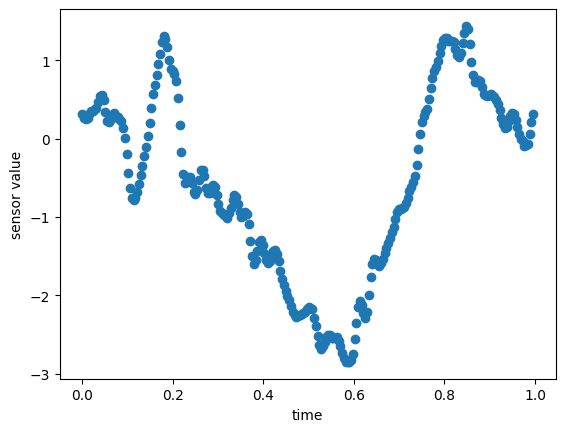

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('time')
plt.ylabel('sensor value') # Changed y-axis label to reflect the values being plotted
# Removed 'sensor position' and instead plotted sensor values from the 'AF3' column as an example.
# You can change 'AF3' to any other sensor position available in your pivoted DataFrame.
plt.scatter(EEG_data_pivoted.index, EEG_data_pivoted['AF3'])

In [ ]:
EEG_data_control_agg = EEG_data_control.groupby(['time', 'sensor position']).agg({'sensor value': 'mean'}).reset_index()
EEG_data_control_pivoted = EEG_data_control_agg.pivot(index='time', columns='sensor position', values='sensor value')
EEG_data_control_pivoted.drop(columns=['X','Y','nd'],inplace=True)
EEG_data_control_pivoted

sensor position,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.627552,0.656882,0.659562,0.918776,0.547712,0.628865,0.656742,0.018871,0.056015,0.154425,...,0.461518,0.328370,1.331598,1.545552,0.225097,0.119524,0.397319,0.366941,0.570784,0.483799
0.003906,0.486148,0.568135,0.663693,0.786624,0.429008,-0.012180,-0.052450,-0.019330,0.160262,0.078051,...,0.476994,0.451214,1.061129,0.821930,0.275664,0.188674,0.421070,0.328723,0.571818,0.444592
0.007812,0.345732,0.417402,0.611027,0.592577,0.261778,-0.017381,-0.127825,-0.063698,0.107617,0.019201,...,0.559596,0.608106,1.178816,1.058326,0.404712,0.355920,0.403543,0.241998,0.587290,0.465209
0.011719,0.220829,0.267708,0.515034,0.445983,0.110032,-0.028719,-0.146385,-0.121545,0.125180,-0.021053,...,0.737154,0.768140,1.102436,1.128516,0.559569,0.497334,0.314729,0.160490,0.587319,0.457994
0.015625,0.179545,0.198558,0.387025,0.423281,0.033626,0.341875,0.246926,-0.096774,0.077685,-0.047896,...,0.902321,0.860004,1.819901,1.524882,0.717486,0.579930,0.188801,0.111907,0.613118,0.444584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.980469,1.176753,1.302061,2.017036,3.264175,1.077313,-0.966032,-0.535581,-1.693721,-1.027920,-2.536744,...,-5.349323,-5.891279,-6.364226,-6.415600,-5.441254,-2.806053,-3.269414,-1.891759,-4.535000,-3.802328
0.984375,1.083818,1.245313,1.964381,3.147493,1.017433,-1.000110,-0.605780,-1.731932,-0.885463,-2.562594,...,-5.303918,-5.792195,-6.468518,-6.582829,-5.377247,-2.709019,-3.247717,-1.774082,-4.548436,-3.562831
0.988281,1.041516,1.178216,1.900391,2.977165,0.969913,-1.067214,-0.593376,-1.810408,-0.683121,-2.615241,...,-5.296706,-5.778770,-6.212501,-6.660249,-5.400977,-2.686279,-3.303490,-1.784423,-4.641345,-3.415237


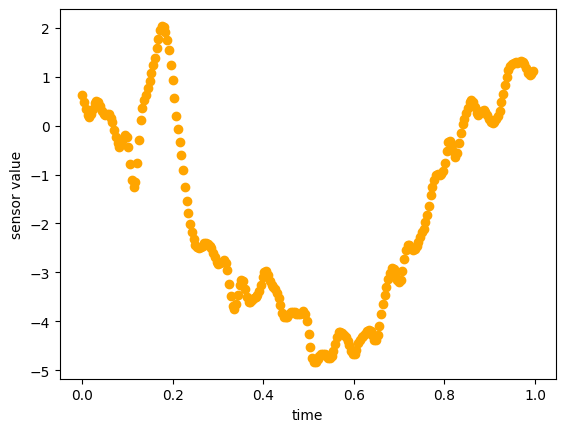

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('time')
plt.ylabel('sensor value') # Changed y-axis label to reflect the values being plotted
# Removed 'sensor position' and instead plotted sensor values from the 'AF3' column as an example.
# You can change 'AF3' to any other sensor position available in your pivoted DataFrame.
plt.scatter(EEG_data_control_pivoted.index, EEG_data_control_pivoted['AF3'],color="orange")

In [ ]:
EEG_data_control_pivoted.to_csv('EEG_data_control_pivoted.csv')

In [ ]:

file_path_alcoholic = '/content/EEG_data_pivoted.csv'
file_path_control = '/content/EEG_data_control_pivoted.csv'

eeg_alcoholic = pd.read_csv(file_path_alcoholic)
eeg_control = pd.read_csv(file_path_control)

In [ ]:
eeg_alcoholic.head(), eeg_control.head()

(       time       AF3       AF4       AF7       AF8       AFz        C1  \
 0  0.000000  0.312027  0.150827  0.293642 -0.108623  0.237417  0.507324   
 1  0.003906  0.265792  0.152901  0.258676 -0.190884  0.202461  0.096116   
 2  0.007812  0.246248  0.177560  0.253505 -0.151827  0.183981  0.170160   
 3  0.011719  0.267832  0.226899  0.340876  0.042459  0.222013  0.043709   
 4  0.015625  0.321303  0.291632  0.508469  0.212067  0.268248  0.313017   
 
          C2        C3        C4  ...       PO3       PO4       PO7       PO8  \
 0  0.277484  0.327225 -0.019539  ...  0.169909  0.034352  0.394147  0.573855   
 1 -0.088440  0.306655 -0.111027  ...  0.199680  0.070301  0.432158  0.335377   
 2 -0.076124  0.398168 -0.137783  ...  0.227438  0.077476  0.530846  0.342568   
 3 -0.007248  0.234722  0.119227  ...  0.232596 -0.020160  0.433196 -0.089131   
 4  0.129488  0.367337 -0.046286  ...  0.183261 -0.137335  0.433208  0.289097   
 
         POz        Pz        T7        T8       TP7  

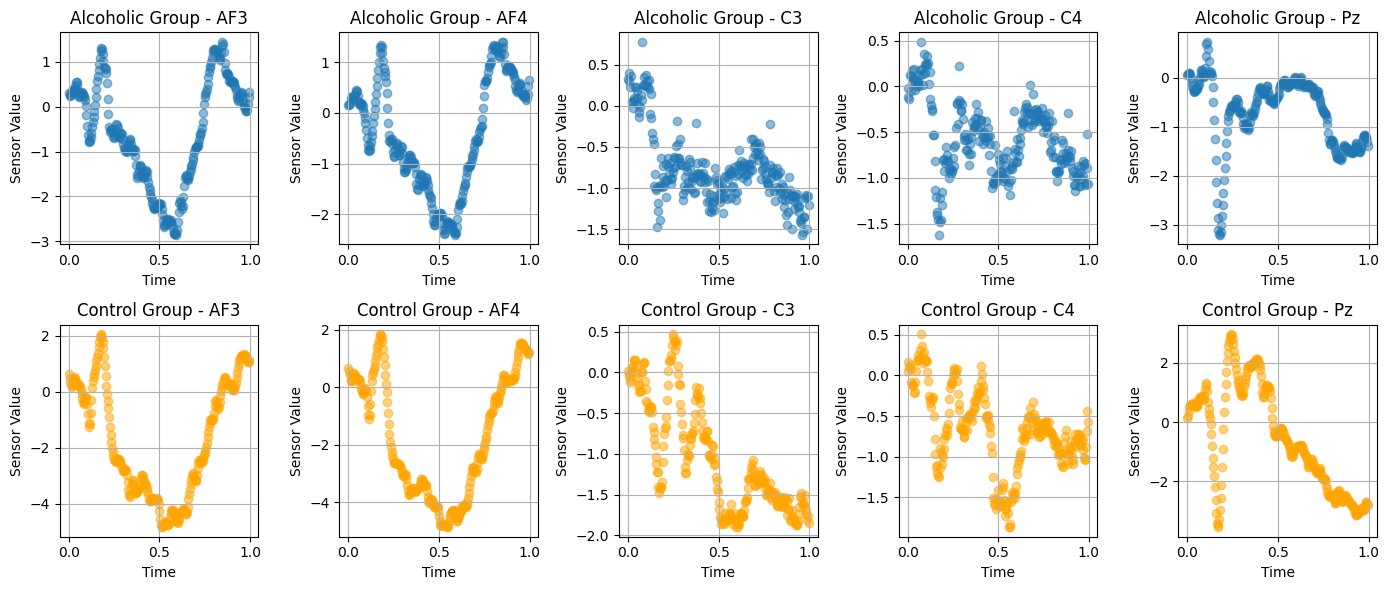

In [ ]:

# Selecting a few representative sensors for visualization
sensors_to_plot = ['AF3', 'AF4', 'C3', 'C4', 'Pz']

# Plotting scatter plots for alcoholic group
plt.figure(figsize=(14, 6))
for i, sensor in enumerate(sensors_to_plot):
    plt.subplot(2, len(sensors_to_plot), i + 1)
    plt.scatter(eeg_alcoholic['time'], eeg_alcoholic[sensor], alpha=0.5, label='Alcoholic')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.title(f'Alcoholic Group - {sensor}')
    plt.grid(True)

# Plotting scatter plots for control group
for i, sensor in enumerate(sensors_to_plot):
    plt.subplot(2, len(sensors_to_plot), i + 1 + len(sensors_to_plot))
    plt.scatter(eeg_control['time'], eeg_control[sensor], alpha=0.5, color='orange', label='Control')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.title(f'Control Group - {sensor}')
    plt.grid(True)

plt.tight_layout()
plt.show()


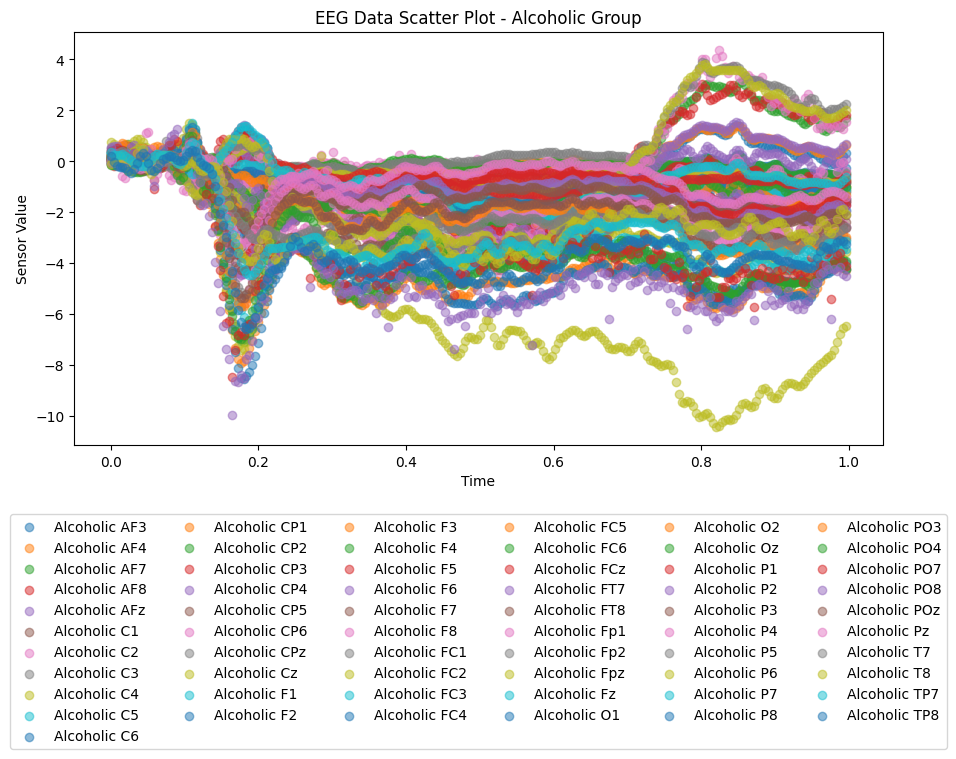

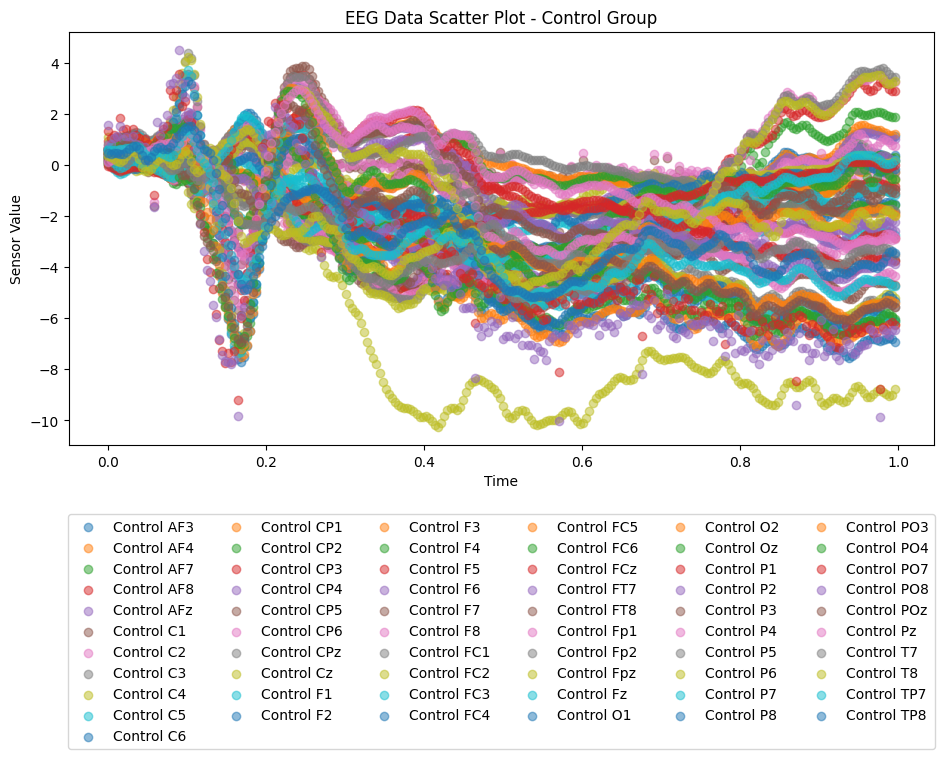

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the EEG datasets
file_path_alcoholic = '/content/EEG_data_pivoted.csv'
file_path_control = '/content/EEG_data_control_pivoted.csv'

eeg_alcoholic = pd.read_csv(file_path_alcoholic)
eeg_control = pd.read_csv(file_path_control)

# Scatter plot for the alcoholic group (time vs sensor values)
plt.figure(figsize=(10, 8))
for column in eeg_alcoholic.columns:
    if column != 'time':
        plt.scatter(eeg_alcoholic['time'], eeg_alcoholic[column], label=f'Alcoholic {column}', alpha=0.5)

plt.title('EEG Data Scatter Plot - Alcoholic Group')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
# Place the legend below the plot in a row order
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.tight_layout()
plt.show()

# Scatter plot for the control group (time vs sensor values)
plt.figure(figsize=(10, 8))
for column in eeg_control.columns:
    if column != 'time':
        plt.scatter(eeg_control['time'], eeg_control[column], label=f'Control {column}', alpha=0.5)

plt.title('EEG Data Scatter Plot - Control Group')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
# Place the legend below the plot in a row order
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.tight_layout()
plt.show()
#For each group (alcoholic and control),
#we can plot a scatter plot using time on the x-axis and sensor values (e.g., 61 electrodes) on the y-axis.


#KNN

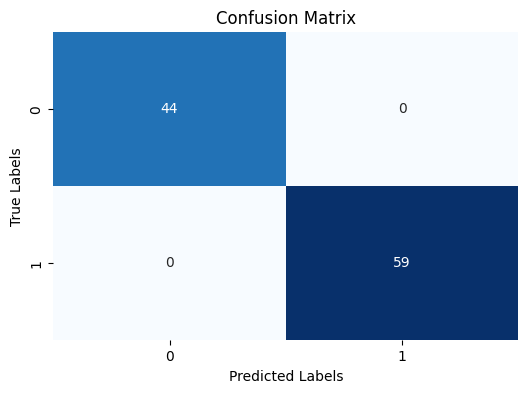

Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     44.0
1                   1.0     1.0       1.0     59.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    103.0
weighted avg        1.0     1.0       1.0    103.0


In [ ]:
# Importing necessary libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Preparing the data
# Adding a label to distinguish between alcoholic (1) and control (0)
eeg_alcoholic['label'] = 1
eeg_control['label'] = 0

# Combining both datasets
eeg_combined = pd.concat([eeg_alcoholic, eeg_control], ignore_index=True)

# Defining features (sensor data) and label
X = eeg_combined.drop(['time', 'label'], axis=1)
y = eeg_combined['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Making predictions
y_pred = knn.predict(X_test_scaled)

# Evaluating the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Displaying the classification report in a tabular form
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

# Showing the classification report
print("Classification Report:")
print(report_df)


In [ ]:
# Importing necessary libraries
from sklearn.metrics import accuracy_score

# Extracting the overall metrics from the classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Computing the overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Extracting precision, recall, and F1-score for each class
precision_alcoholic = report_dict['1']['precision']
recall_alcoholic = report_dict['1']['recall']
f1_alcoholic = report_dict['1']['f1-score']

precision_control = report_dict['0']['precision']
recall_control = report_dict['0']['recall']
f1_control = report_dict['0']['f1-score']

# Extracting macro and weighted averages
macro_avg_precision = report_dict['macro avg']['precision']
macro_avg_recall = report_dict['macro avg']['recall']
macro_avg_f1 = report_dict['macro avg']['f1-score']

weighted_avg_precision = report_dict['weighted avg']['precision']
weighted_avg_recall = report_dict['weighted avg']['recall']
weighted_avg_f1 = report_dict['weighted avg']['f1-score']

# Printing the overall report
print("Overall Classification Report Summary:")
print(f"Accuracy: {accuracy:.2f}")
print("\nClass 1 (Alcoholic):")
print(f"  Precision: {precision_alcoholic:.2f}")
print(f"  Recall: {recall_alcoholic:.2f}")
print(f"  F1-Score: {f1_alcoholic:.2f}")
print("\nClass 0 (Control):")
print(f"  Precision: {precision_control:.2f}")
print(f"  Recall: {recall_control:.2f}")
print(f"  F1-Score: {f1_control:.2f}")
print("\nMacro Average:")
print(f"  Precision: {macro_avg_precision:.2f}")
print(f"  Recall: {macro_avg_recall:.2f}")
print(f"  F1-Score: {macro_avg_f1:.2f}")
print("\nWeighted Average:")
print(f"  Precision: {weighted_avg_precision:.2f}")
print(f"  Recall: {weighted_avg_recall:.2f}")
print(f"  F1-Score: {weighted_avg_f1:.2f}")


Overall Classification Report Summary:
Accuracy: 1.00

Class 1 (Alcoholic):
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Class 0 (Control):
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Macro Average:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Weighted Average:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00


#SVM

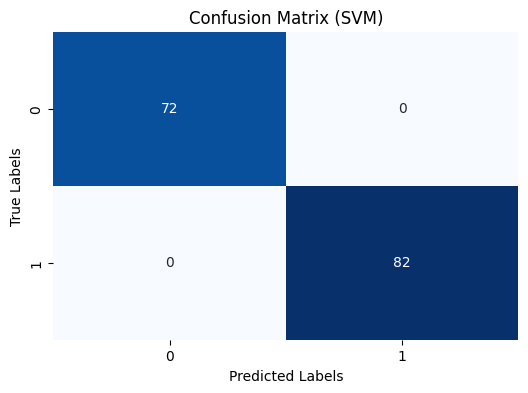

Classification Report (SVM):
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     72.0
1                   1.0     1.0       1.0     82.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    154.0
weighted avg        1.0     1.0       1.0    154.0


In [ ]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load the data from the uploaded CSV files
file_path_alcoholic = 'EEG_data_pivoted.csv'  # Replace with your file path
file_path_control = 'EEG_data_control_pivoted.csv'  # Replace with your file path

# Reading the CSV files
eeg_alcoholic = pd.read_csv(file_path_alcoholic)
eeg_control = pd.read_csv(file_path_control)

# Preparing the data
# Adding a label to distinguish between alcoholic (1) and control (0)
eeg_alcoholic['label'] = 1
eeg_control['label'] = 0

# Combining both datasets
eeg_combined = pd.concat([eeg_alcoholic, eeg_control], ignore_index=True)

# Defining features (sensor data) and label
X = eeg_combined.drop(['time', 'label'], axis=1)
y = eeg_combined['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the SVM classifier
svm = SVC(kernel='rbf', C=1, gamma='scale')  # Using radial basis function kernel
svm.fit(X_train_scaled, y_train)

# Making predictions
y_pred_svm = svm.predict(X_test_scaled)

# Evaluating the model
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Displaying the classification report in a tabular form
report_svm_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()

# Showing the classification report
print("Classification Report (SVM):")
print(report_svm_df)


plot the SVM decision boundary for a 2D dataset (or reduced 2D space)

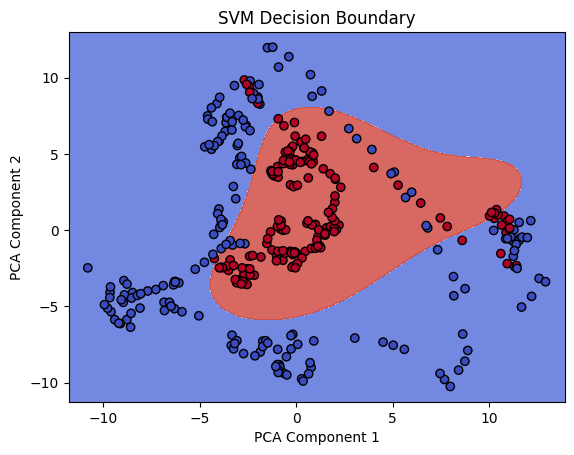

In [ ]:
# Importing PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Reducing the feature space to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)##PCA (Principal Component Analysis) is used to reduce the dimensionality of the dataset from its original number of features (likely more than 2 for EEG data)
#to just 2 principal components. This reduction allows for easy plotting while retaining as much of the variance (information) in the data as possible.

# Training the SVM on the 2D PCA-transformed data
svm_pca = SVC(kernel='rbf', C=1, gamma='scale')#(SVM) classifier is trained on the PCA-reduced 2D data.
svm_pca.fit(X_train_pca, y_train)#The Radial Basis Function (RBF) kernel is used, which is a popular choice for SVM in non-linear classification tasks.

# Plotting the decision boundary for the 2D data
def plot_svm_decision_boundary(X, y, model):
    # Define grid range for plotting
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the entire grid to plot the decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title('SVM Decision Boundary')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Plotting the decision boundary using the reduced 2D data
plot_svm_decision_boundary(X_train_pca, y_train, svm_pca)


Meshgrid (xx, yy): A grid of points is generated across the entire feature space, extending slightly beyond the minimum and maximum values of the 2D data points.

Model Predictions (Z): The trained SVM model is used to predict the class label for each point in the grid.

 Contour Plot (plt.contourf): The predicted labels from Z are reshaped and plotted as a contour map, coloring the regions in the 2D space according to the predicted class (alcoholic vs control).

 Scatter Plot (plt.scatter): The actual data points are overlaid on the contour plot. Each point is colored according to its true label (e.g., alcoholic or control).

This function effectively visualizes how the SVM's decision boundary separates the two classes (in this case, alcoholic vs control) in the reduced 2D space.

The function plot_SVM_decision_boundary creates a mesh grid to visualize how SVM classifies the regions between the two classes (alcoholic and control).

The scatter plot shows the PCA-reduced data,

while the contour plot shows the decision boundary of the KNN model.

The Decision Boundary Explanation
The decision boundary represents the line (or curve) that the SVM model uses to separate the two classes (e.g., alcoholic and control) in the dataset. SVM tries to find the hyperplane (a generalization of a line in higher dimensions) that best separates the classes by maximizing the margin between the support vectors (the closest data points to the boundary from either class).

Interpretation of the Plot:

The regions on one side of the decision boundary (contour line) correspond to the alcoholic class (1), and the regions on the other side correspond to the control class (0).
Data points correctly classified by the SVM will fall in their corresponding region, while misclassified points will be on the wrong side of the boundary.
The width of the margin (the area between the boundary and the nearest data points) shows the confidence of the classification. A wider margin means the model is more confident.

Red Dots represent data points from one class (likely the alcoholic class, since you assigned a label 1 to alcoholic samples in the dataset).
Blue Dots represent data points from the other class (likely the control class, since you assigned a label 0 to control samples).
Color Scheme:
The red region indicates the area where the SVM classifier predicts the data points belong to the alcoholic class (label 1).
The blue region indicates the area where the classifier predicts the data points belong to the control class (label 0).
Interpretation:
Red dots within the red region are correctly classified as alcoholic.
Blue dots within the blue region are correctly classified as control.
Any dots that appear in the "wrong" color region are misclassified by the model. For example, red dots in the blue region are alcoholic samples predicted as control, and blue dots in the red region are control samples predicted as alcoholic.

In [ ]:
# Importing necessary libraries
from sklearn.metrics import accuracy_score

# Extracting the overall metrics from the classification report
report_svm_dict = classification_report(y_test, y_pred_svm, output_dict=True)

# Computing the overall accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Extracting precision, recall, and F1-score for each class
precision_alcoholic_svm = report_svm_dict['1']['precision']
recall_alcoholic_svm = report_svm_dict['1']['recall']
f1_alcoholic_svm = report_svm_dict['1']['f1-score']

precision_control_svm = report_svm_dict['0']['precision']
recall_control_svm = report_svm_dict['0']['recall']
f1_control_svm = report_svm_dict['0']['f1-score']

# Extracting macro and weighted averages
macro_avg_precision_svm = report_svm_dict['macro avg']['precision']
macro_avg_recall_svm = report_svm_dict['macro avg']['recall']
macro_avg_f1_svm = report_svm_dict['macro avg']['f1-score']

weighted_avg_precision_svm = report_svm_dict['weighted avg']['precision']
weighted_avg_recall_svm = report_svm_dict['weighted avg']['recall']
weighted_avg_f1_svm = report_svm_dict['weighted avg']['f1-score']

# Printing the overall report
print("Overall Classification Report Summary (SVM):")
print(f"Accuracy: {accuracy_svm:.2f}")
print("\nClass 1 (Alcoholic):")
print(f"  Precision: {precision_alcoholic_svm:.2f}")
print(f"  Recall: {recall_alcoholic_svm:.2f}")
print(f"  F1-Score: {f1_alcoholic_svm:.2f}")
print("\nClass 0 (Control):")
print(f"  Precision: {precision_control_svm:.2f}")
print(f"  Recall: {recall_control_svm:.2f}")
print(f"  F1-Score: {f1_control_svm:.2f}")
print("\nMacro Average:")
print(f"  Precision: {macro_avg_precision_svm:.2f}")
print(f"  Recall: {macro_avg_recall_svm:.2f}")
print(f"  F1-Score: {macro_avg_f1_svm:.2f}")
print("\nWeighted Average:")
print(f"  Precision: {weighted_avg_precision_svm:.2f}")
print(f"  Recall: {weighted_avg_recall_svm:.2f}")
print(f"  F1-Score: {weighted_avg_f1_svm:.2f}")


Overall Classification Report Summary (SVM):
Accuracy: 1.00

Class 1 (Alcoholic):
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Class 0 (Control):
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Macro Average:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Weighted Average:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00


#K-means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


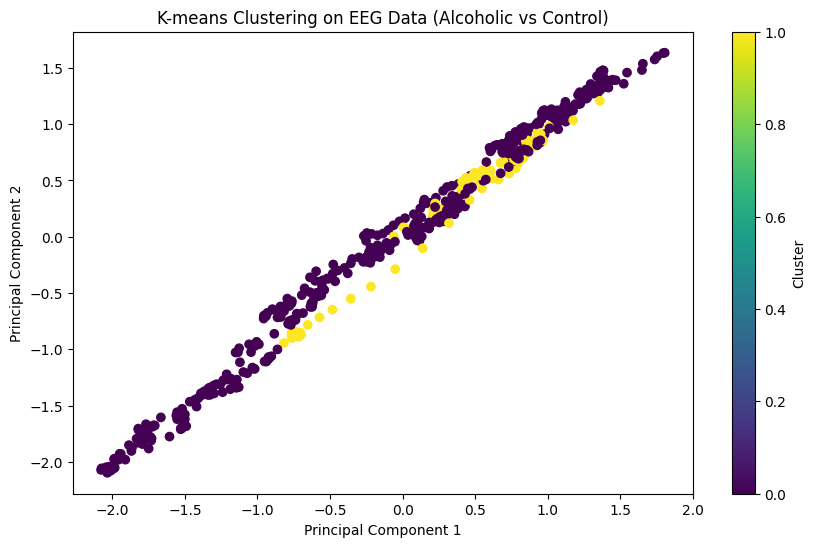

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the provided EEG data files
eeg_data_alcoholic_path = '/content/drive/MyDrive/Colab_Notebooks/EEG_data_pivoted.csv'
eeg_data_control_path = '/content/drive/MyDrive/Colab_Notebooks/EEG_data_control_pivoted.csv'

# Read the CSV files into DataFrames
eeg_data_alcoholic = pd.read_csv(eeg_data_alcoholic_path)
eeg_data_control = pd.read_csv(eeg_data_control_path)

# Add labels to distinguish between alcoholic and control groups
eeg_data_alcoholic['label'] = 'alcoholic'
eeg_data_control['label'] = 'control'

# Concatenate both datasets into one DataFrame
eeg_combined = pd.concat([eeg_data_alcoholic, eeg_data_control])

# Separate features and labels
X = eeg_combined.drop(columns=['label', 'time'])  # Drop the label and time columns for clustering
y = eeg_combined['label']  # The true labels for later comparison

# Standardize the feature values (sensor data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit KMeans clustering (trying 2 clusters for alcoholic vs control distinction)
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Get the predicted cluster labels
cluster_labels = kmeans.labels_

# Visualize the clustering
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', marker='o', label='Data Points')
plt.title('K-means Clustering on EEG Data (Alcoholic vs Control)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Map the predicted cluster labels to true labels
# Since K-means doesn't know which cluster corresponds to which group, we need to map them
# Assuming that the majority of one cluster corresponds to 'alcoholic' and the other to 'control'

# Map predicted clusters to labels (0 -> 'alcoholic', 1 -> 'control' or vice-versa)
# We can use a simple heuristic: check which cluster is dominant for each true label
true_labels_numeric = np.where(y == 'alcoholic', 0, 1)  # Convert true labels to numeric (0: alcoholic, 1: control)
cluster_mapping = {0: 1, 1: 0} if sum(cluster_labels == 0) > sum(cluster_labels == 1) else {0: 0, 1: 1}

# Apply the mapping to the predicted labels
mapped_cluster_labels = np.array([cluster_mapping[label] for label in cluster_labels])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels_numeric, mapped_cluster_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(true_labels_numeric, mapped_cluster_labels, target_names=['Alcoholic', 'Control'])
print("\nClassification Report:")
print(class_report)



Confusion Matrix:
[[ 38 218]
 [ 61 195]]

Classification Report:
              precision    recall  f1-score   support

   Alcoholic       0.38      0.15      0.21       256
     Control       0.47      0.76      0.58       256

    accuracy                           0.46       512
   macro avg       0.43      0.46      0.40       512
weighted avg       0.43      0.46      0.40       512

